 <div class="alert alert-block alert-info" style="margin-top: 20px">
    
<h1 align=center><font size = 5> Group Final Project: Employee Churn at Dunder Mifflin Paper Company </h1>
</div>



<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Import data </h1>

In [297]:
# Install Required Libraries
!pip install mlxtend --quiet

In [298]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder


In [299]:
#Load Dataset
df = pd.read_csv("office_churn_dataset.csv")
print("Initial Shape:", df.shape)
df.head()

Initial Shape: (1543, 17)


,EmployeeID,Branch,Tenure,Salary,Department,JobSatisfaction,WorkLifeBalance,CommuteDistance,MaritalStatus,Education,PerformanceRating,TrainingHours,OverTime,NumProjects,YearsSincePromotion,EnvironmentSatisfaction,ChurnLikelihood
0,1,San Francisco,4.0,63000.0,Legal,3.0,3.0,Long,Married,High School,3.000000,88.0,True,3.0,0.0,2.0,Highly Likely to Churn
1,2,Chicago,14.0,72000.0,Accounting,4.0,4.0,Short,Single,Bachelor,3.666667,30.0,True,3.0,2.0,3.0,Moderately Likely to Churn
2,3,Miami,4.0,40000.0,Quality Assurance,3.0,3.0,Medium,Single,High School,3.666667,64.0,NaN,NaN,0.0,4.0,Highly Likely to Churn
3,4,Scranton,2.0,55000.0,Legal,3.0,3.5,Short,Married,Bachelor,3.666667,30.0,True,4.0,0.0,3.0,Moderately Likely to Churn
4,5,Scranton,10.0,55500.0,Legal,3.0,3.0,Medium,Married,Bachelor,3.333333,18.0,NaN,4.0,1.0,3.0,Moderately Likely to Churn


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Data Preprocessing </h1>

In [300]:
# Display the number of missing values per column
missing_values = df.isnull().sum()

# Determine data types: 'numeric' or 'character'
data_types = df.dtypes.apply(lambda x: 'numeric' if pd.api.types.is_numeric_dtype(x) else 'character')

# Combine both into one table
summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Data Type': data_types
})
summary

,Missing Values,Data Type
EmployeeID,0,numeric
Branch,8,character
Tenure,9,numeric
Salary,9,numeric
Department,0,character
JobSatisfaction,28,numeric
WorkLifeBalance,28,numeric
CommuteDistance,0,character
MaritalStatus,0,character
Education,0,character


In [301]:
# Handle missing values - with some needed column

# Fill numerical columns with median/mean
df['TrainingHours'] = df['TrainingHours'].fillna(df['TrainingHours'].median())
df['NumProjects'] = df['NumProjects'].fillna(df['NumProjects'].median())
df['PerformanceRating'] = df['PerformanceRating'].fillna(df['PerformanceRating'].mean())

# Fill OverTime with 'False' and convert to binary
df['OverTime'] = df['OverTime'].fillna('False')  # Fill missing with 'False'
df['OverTime'] = df['OverTime'].astype(str).str.strip().str.capitalize()  # Clean and standardize
df['OverTime'] = df['OverTime'].replace({'True': 1, 'False': 0})
df['OverTime'] = df['OverTime'].infer_objects(copy=False).astype(int)  # Convert to binary

# Fill satisfaction scores with mode
satisfaction_cols = ['JobSatisfaction', 'WorkLifeBalance', 'EnvironmentSatisfaction']
for col in satisfaction_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df.head()

/tmp/ipython-input-1755539486.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['OverTime'] = df['OverTime'].replace({'True': 1, 'False': 0})


,EmployeeID,Branch,Tenure,Salary,Department,JobSatisfaction,WorkLifeBalance,CommuteDistance,MaritalStatus,Education,PerformanceRating,TrainingHours,OverTime,NumProjects,YearsSincePromotion,EnvironmentSatisfaction,ChurnLikelihood
0,1,San Francisco,4.0,63000.0,Legal,3.0,3.0,Long,Married,High School,3.000000,88.0,1,3.000000,0.0,2.0,Highly Likely to Churn
1,2,Chicago,14.0,72000.0,Accounting,4.0,4.0,Short,Single,Bachelor,3.666667,30.0,1,3.000000,2.0,3.0,Moderately Likely to Churn
2,3,Miami,4.0,40000.0,Quality Assurance,3.0,3.0,Medium,Single,High School,3.666667,64.0,0,3.618543,0.0,4.0,Highly Likely to Churn
3,4,Scranton,2.0,55000.0,Legal,3.0,3.5,Short,Married,Bachelor,3.666667,30.0,1,4.000000,0.0,3.0,Moderately Likely to Churn
4,5,Scranton,10.0,55500.0,Legal,3.0,3.0,Medium,Married,Bachelor,3.333333,18.0,0,4.000000,1.0,3.0,Moderately Likely to Churn


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Exploratory Data Analysis </h1>

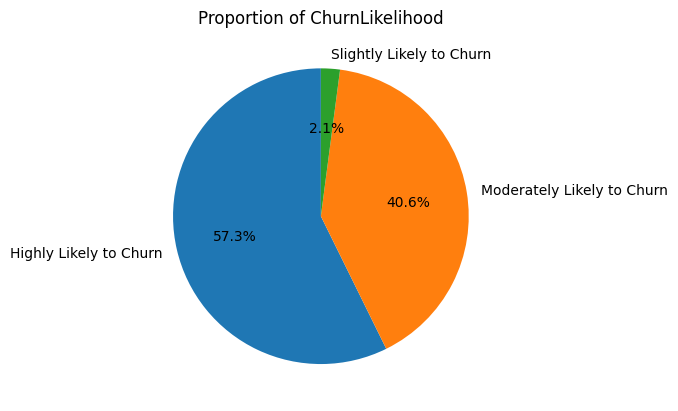

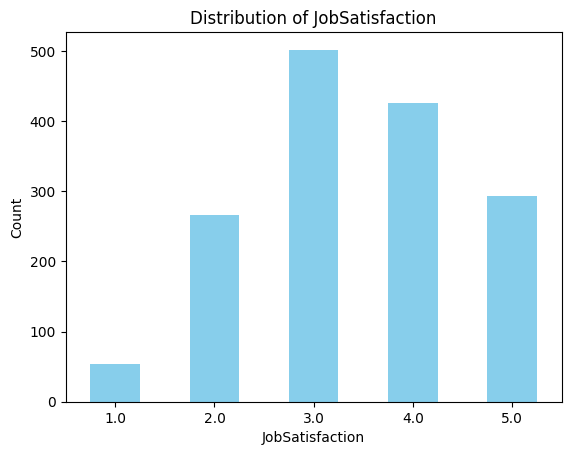

In [302]:
# Pie chart for ChurnLikelihood
churn_counts = df['ChurnLikelihood'].value_counts()
churn_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proportion of ChurnLikelihood')
plt.ylabel('')  # Hide y-label for pie chart
plt.show()

# Plot JobSatisfaction distribution
df['JobSatisfaction'].value_counts().sort_index().plot(kind='bar',color='skyblue')
plt.title('Distribution of JobSatisfaction')
plt.xlabel('JobSatisfaction')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [303]:
# Plot the heatmap to see correlation among variables
import pandas as pd
import matplotlib.pyplot as plt

churn_mapping = {'Slightly Likely to Churn': 0, 'Moderately Likely to Churn': 1, 'Highly Likely to Churn': 2}
df['ChurnLikelihoodEncoded'] = df['ChurnLikelihood'].map(churn_mapping)
df[['ChurnLikelihood', 'ChurnLikelihoodEncoded']].head()

,ChurnLikelihood,ChurnLikelihoodEncoded
0,Highly Likely to Churn,2
1,Moderately Likely to Churn,1
2,Highly Likely to Churn,2
3,Moderately Likely to Churn,1
4,Moderately Likely to Churn,1


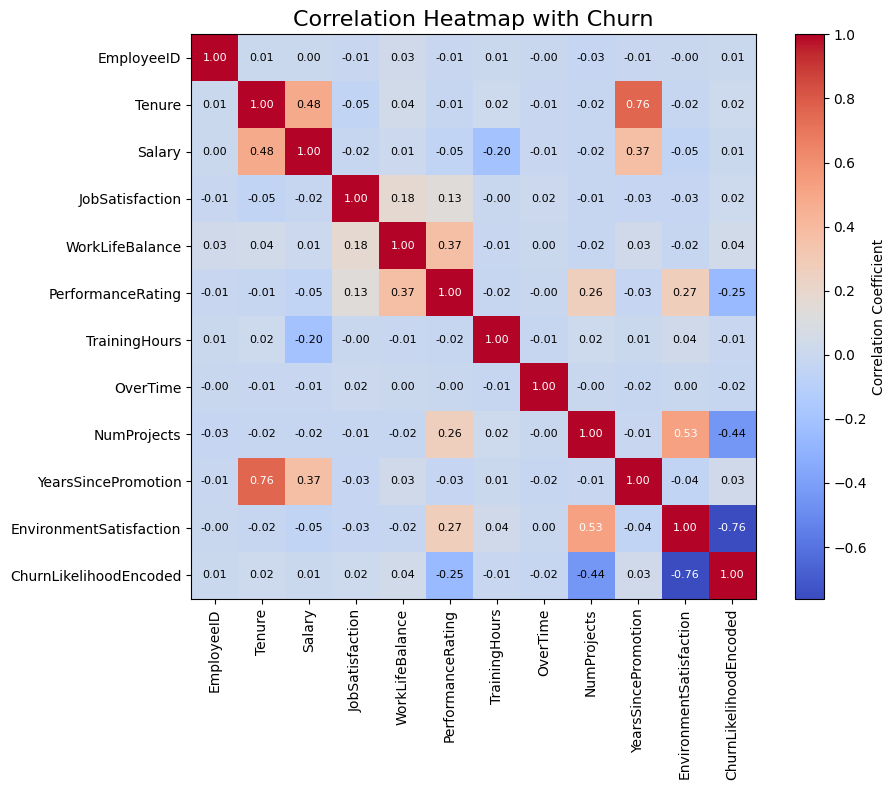

In [304]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
# Add correlation numbers inside the heatmap
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha='center', va='center',
                 color='black' if abs(corr.iloc[i, j]) < 0.5 else 'white',
                 fontsize=8)
# Add labels
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap with Churn", fontsize=16)
plt.tight_layout()
plt.show()

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Association Rule Mining </h1>

In [305]:
# Bin training hours into categories
df['TrainingCategory'] = pd.cut(df['TrainingHours'],
                                bins=[-np.inf, 20, 40, 60, np.inf],
                                labels=['Low', 'Moderate', 'High', 'Very High'])

df[['EmployeeID','TrainingHours','TrainingCategory']].head()

,EmployeeID,TrainingHours,TrainingCategory
0,1,88.0,Very High
1,2,30.0,Moderate
2,3,64.0,Very High
3,4,30.0,Moderate
4,5,18.0,Low


In [306]:
# Select features for Association Rule Mining
arm_df = df[['TrainingCategory', 'OverTime', 'Department', 'JobSatisfaction', 'ChurnLikelihood']].dropna()

# Convert each row into a transaction
transactions = arm_df.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1)

# Encode transactions
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)
df_encoded.head()


,ChurnLikelihood=Highly Likely to Churn,ChurnLikelihood=Moderately Likely to Churn,ChurnLikelihood=Slightly Likely to Churn,Department=Accounting,Department=Administration,Department=Customer Service,Department=Facilities Management,Department=Human Resources,Department=IT Support,Department=Legal,...,JobSatisfaction=2.0,JobSatisfaction=3.0,JobSatisfaction=4.0,JobSatisfaction=5.0,OverTime=0,OverTime=1,TrainingCategory=High,TrainingCategory=Low,TrainingCategory=Moderate,TrainingCategory=Very High
0,True,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
1,False,True,False,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
3,False,True,False,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,True,False
4,False,True,False,False,False,False,False,False,False,True,...,False,True,False,False,True,False,False,True,False,False


In [307]:
# Run Apriori and generate rules
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.572910,(ChurnLikelihood=Highly Likely to Churn)
1,0.406351,(ChurnLikelihood=Moderately Likely to Churn)
2,0.102398,(Department=Accounting)
3,0.104342,(Department=Customer Service)
4,0.057680,(Department=Human Resources)


In [308]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Department=Accounting),(ChurnLikelihood=Highly Likely to Churn),0.102398,0.572910,0.061568,0.601266,1.049495,1.0,0.002904,1.071115,0.052540,0.100317,0.066393,0.354366
1,(JobSatisfaction=5.0),(ChurnLikelihood=Highly Likely to Churn),0.190538,0.572910,0.115360,0.605442,1.056784,1.0,0.006199,1.082452,0.066381,0.178000,0.076172,0.403400
2,(ChurnLikelihood=Highly Likely to Churn),(OverTime=1),0.572910,0.935191,0.532728,0.929864,0.994304,1.0,-0.003052,0.924048,-0.013236,0.546179,-0.082195,0.749755
3,(TrainingCategory=Low),(ChurnLikelihood=Highly Likely to Churn),0.278030,0.572910,0.167855,0.603730,1.053795,1.0,0.008569,1.077774,0.070708,0.245731,0.072162,0.448358
4,(ChurnLikelihood=Moderately Likely to Churn),(OverTime=1),0.406351,0.935191,0.383668,0.944179,1.009610,1.0,0.003652,1.161004,0.016034,0.400541,0.138676,0.677218


In [309]:
# Show only rules that lead to churn
churn_rules = rules[rules['consequents'].apply(lambda x: any('ChurnLikelihood' in i for i in x))]
churn_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(Department=Accounting),(ChurnLikelihood=Highly Likely to Churn),0.061568,0.601266,1.049495
1,(JobSatisfaction=5.0),(ChurnLikelihood=Highly Likely to Churn),0.115360,0.605442,1.056784
3,(TrainingCategory=Low),(ChurnLikelihood=Highly Likely to Churn),0.167855,0.603730,1.053795
25,"(JobSatisfaction=3.0, TrainingCategory=Low)",(ChurnLikelihood=Highly Likely to Churn),0.060920,0.652778,1.139407
28,"(JobSatisfaction=5.0, OverTime=1)",(ChurnLikelihood=Highly Likely to Churn),0.109527,0.612319,1.068787
30,"(OverTime=1, TrainingCategory=Low)",(ChurnLikelihood=Highly Likely to Churn),0.160726,0.607843,1.060975
49,"(JobSatisfaction=3.0, OverTime=1, TrainingCate...",(ChurnLikelihood=Highly Likely to Churn),0.058976,0.659420,1.151002
50,"(JobSatisfaction=3.0, TrainingCategory=Low)","(ChurnLikelihood=Highly Likely to Churn, OverT...",0.058976,0.631944,1.186241


**Comments:** It only shows rules leading to 'highly likely to churn', there is too small data to find the rules of 'low likely to churn'.

If Department = Accounting,
ChurnLikelihood = Highly Likely to Churn

support = 6.16% → About 6% of employees are in this situation

confidence = 60.1% → 60% of Accounting employees are highly likely to churn

lift = 1.05 → Slightly more likely than average (5% more)

There is a slightly elevated churn risk in the Accounting department. This may suggest dissatisfaction or role mismatch in that team.

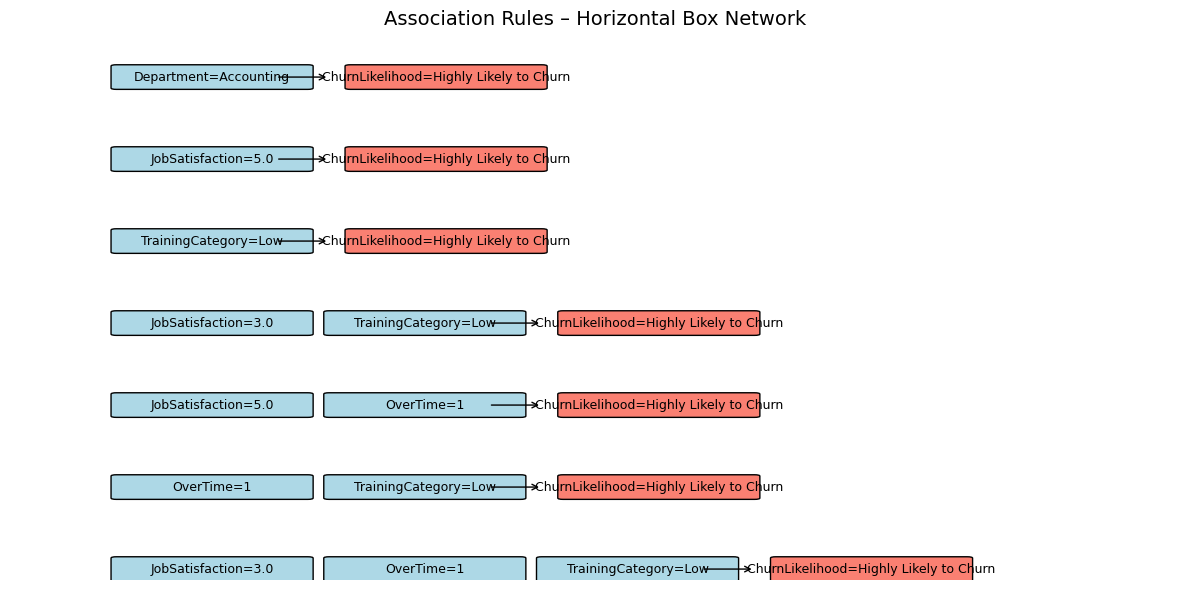

In [310]:
# visualize some above rules
import matplotlib.patches as patches

# churn rules (antecedents ➜ consequent)
visualize_rules=[
    ({"Department=Accounting"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"JobSatisfaction=5.0"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"TrainingCategory=Low"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"JobSatisfaction=3.0", "TrainingCategory=Low"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"OverTime=1", "JobSatisfaction=5.0"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"TrainingCategory=Low", "OverTime=1"}, "ChurnLikelihood=Highly Likely to Churn"),
    ({"JobSatisfaction=3.0", "TrainingCategory=Low", "OverTime=1"}, "ChurnLikelihood=Highly Likely to Churn"),
]

# Create a horizontal box network-style visualization
fig, ax = plt.subplots(figsize=(12, 6))

y_level = 0
box_width = 1.8
box_height = 0.8
spacing = 3

for idx, (antecedents, consequent) in enumerate(visualize_rules):
    # Draw antecedent boxes
    x = 0
    for ant in antecedents:
        rect = patches.FancyBboxPatch(
            (x, y_level), box_width, box_height,
            boxstyle="round,pad=0.05", edgecolor='black', facecolor='lightblue'
        )
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y_level + box_height / 2, ant, ha='center', va='center', fontsize=9)
        x += box_width + 0.2

    # Draw arrow to consequent
    ax.annotate('', xy=(x, y_level + box_height / 2), xytext=(x - 0.5, y_level + box_height / 2),
                arrowprops=dict(facecolor='gray', arrowstyle='->'))

    # Draw consequent box
    rect = patches.FancyBboxPatch(
        (x + 0.2, y_level), box_width, box_height,
        boxstyle="round,pad=0.05", edgecolor='black', facecolor='salmon'
    )
    ax.add_patch(rect)
    ax.text(x + box_width / 2 + 0.2, y_level + box_height / 2, consequent, ha='center', va='center', fontsize=9)

    y_level -= spacing

# Format plot
ax.set_xlim(-1, 10)
ax.set_ylim(y_level + spacing, 2)
ax.axis('off')
plt.title("Association Rules – Horizontal Box Network", fontsize=14)
plt.tight_layout()
plt.show()


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Data Cleaning for Clustering </h1>

In [311]:
df_clustering = df.copy()

# Drop irrelevant columns
df_clustering = df_clustering.drop(columns=['EmployeeID'], errors='ignore')
df_clustering.head(2)

,Branch,Tenure,Salary,Department,JobSatisfaction,WorkLifeBalance,CommuteDistance,MaritalStatus,Education,PerformanceRating,TrainingHours,OverTime,NumProjects,YearsSincePromotion,EnvironmentSatisfaction,ChurnLikelihood,ChurnLikelihoodEncoded,TrainingCategory
0,San Francisco,4.0,63000.0,Legal,3.0,3.0,Long,Married,High School,3.000000,88.0,1,3.0,0.0,2.0,Highly Likely to Churn,2,Very High
1,Chicago,14.0,72000.0,Accounting,4.0,4.0,Short,Single,Bachelor,3.666667,30.0,1,3.0,2.0,3.0,Moderately Likely to Churn,1,Moderate


In [312]:
missing_cols = df_clustering.isnull().sum()
missing_cols = missing_cols[missing_cols > 0]
missing_cols

,0
Branch,8
Tenure,9
Salary,9
YearsSincePromotion,1


In [313]:
# Fill categorical NaNs with most frequent value
for col in ['Branch']:
    df_clustering[col] = df_clustering[col].fillna(df_clustering[col].mode()[0])

# Fill numeric NaNs with median
num_cols = df_clustering.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df_clustering[col] = df_clustering[col].fillna(df_clustering[col].median())

## Divide into 2 groups: High churn risk and Moderate churn risk

In [314]:
df_high_risk = df_clustering[df_clustering['ChurnLikelihoodEncoded'] == 2].copy()
df_moderate_risk = df_clustering[df_clustering['ChurnLikelihoodEncoded'] == 1].copy()

In [315]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
def preprocess(df, categorical_cols):
    # One-hot encode categorical columns
    encoder = OneHotEncoder(drop='first',sparse_output=False)
    encoded = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
    # Numeric columns only (exclude some columns)
    df_num = df.drop(columns=categorical_cols + ['ChurnLikelihood', 'ChurnLikelihoodEncoded'], errors='ignore').reset_index(drop=True)
    # Combine numeric and encoded columns
    combined = pd.concat([df_num, encoded_df], axis=1)
    # Scale all features
    scaler = StandardScaler()
    scaled = scaler.fit_transform(combined)
    return scaled, combined

In [316]:
from sklearn.cluster import KMeans

def cluster(df, scaled_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    df['Cluster'] = clusters
    return df

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Clustering for each group </h1>

In [317]:
categorical_columns = ['Branch', 'MaritalStatus', 'Education', 'Department', 'CommuteDistance','TrainingCategory']

# High risk group
scaled_high, combined_high = preprocess(df_high_risk, categorical_columns)
df_high_risk = cluster(df_high_risk, scaled_high, n_clusters=3)

# Moderate risk group
scaled_moderate, combined_moderate = preprocess(df_moderate_risk, categorical_columns)
df_moderate_risk = cluster(df_moderate_risk, scaled_moderate, n_clusters=3)

Because the low likelihood group contains only 2.1% of the total employees, it represents a very small sample size.

From a clustering perspective, this presents several problems:

Insufficient data for reliable patterns – Clustering algorithms (e.g., K-Means) rely on detecting structure in the data. When a group has very few observations, the algorithm cannot form stable, meaningful clusters for that group.

In [318]:
df_high_risk.head(2)

,Branch,Tenure,Salary,Department,JobSatisfaction,WorkLifeBalance,CommuteDistance,MaritalStatus,Education,PerformanceRating,TrainingHours,OverTime,NumProjects,YearsSincePromotion,EnvironmentSatisfaction,ChurnLikelihood,ChurnLikelihoodEncoded,TrainingCategory,Cluster
0,San Francisco,4.0,63000.0,Legal,3.0,3.0,Long,Married,High School,3.000000,88.0,1,3.000000,0.0,2.0,Highly Likely to Churn,2,Very High,2
2,Miami,4.0,40000.0,Quality Assurance,3.0,3.0,Medium,Single,High School,3.666667,64.0,0,3.618543,0.0,4.0,Highly Likely to Churn,2,Very High,2


In [319]:
df_moderate_risk.head(2)

,Branch,Tenure,Salary,Department,JobSatisfaction,WorkLifeBalance,CommuteDistance,MaritalStatus,Education,PerformanceRating,TrainingHours,OverTime,NumProjects,YearsSincePromotion,EnvironmentSatisfaction,ChurnLikelihood,ChurnLikelihoodEncoded,TrainingCategory,Cluster
1,Chicago,14.0,72000.0,Accounting,4.0,4.0,Short,Single,Bachelor,3.666667,30.0,1,3.0,2.0,3.0,Moderately Likely to Churn,1,Moderate,0
3,Scranton,2.0,55000.0,Legal,3.0,3.5,Short,Married,Bachelor,3.666667,30.0,1,4.0,0.0,3.0,Moderately Likely to Churn,1,Moderate,2


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Visualize Clusters with PCA </h1>

In [320]:
def plot_clusters(df, scaled_data, title):
    # Reduce dimensions to 2D for plotting
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(8,6))

    # Plot each cluster with different color
    clusters = df['Cluster'].unique()
    for cluster in clusters:
        idx = df['Cluster'] == cluster
        plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Cluster {cluster}', alpha=0.6)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

## Analyzing High Risk Group

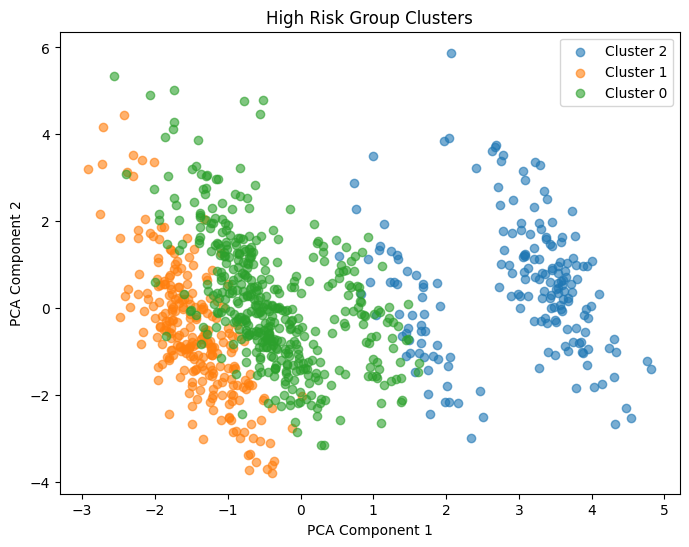

In [321]:
plot_clusters(df_high_risk, scaled_high, 'High Risk Group Clusters')

In [322]:
print("Numeric feature means per cluster:")
print(df_high_risk.groupby('Cluster').mean(numeric_only=True))

Numeric feature means per cluster:
           Tenure        Salary  JobSatisfaction  WorkLifeBalance  \
Cluster                                                             
0        7.662844  67478.211009         3.408257         3.793119   
1        7.729730  68081.081081         3.509653         3.818976   
2        7.698413  63412.698413         3.523810         3.779645   

         PerformanceRating  TrainingHours  OverTime  NumProjects  \
Cluster                                                            
0                 3.392193      29.867255  0.912844     3.242277   
1                 3.444174      13.445247  0.957529     3.251148   
2                 3.404725      70.698009  0.931217     3.267081   

         YearsSincePromotion  EnvironmentSatisfaction  ChurnLikelihoodEncoded  
Cluster                                                                        
0                   1.298165                 2.051146                     2.0  
1                   1.196911          


**Interpretation:**

Cluster 2 stands out with lower salary, higher training hours, and slightly better job & environment satisfaction. This might indicate employees who get more training but still have lower pay — possibly newer or less senior staff feeling somewhat supported but still at risk.

Cluster 1 shows highest salary, highest performance rating, and most overtime work. These employees might be high performers working hard but potentially stressed by overtime.

Cluster 0 is intermediate but has longest time since promotion, which could signal stagnation or lack of advancement, possibly contributing to churn risk.

The OverTime values suggest a majority in all clusters work overtime, but cluster 1 more so.

Job satisfaction and work-life balance vary only slightly, so these factors might not differentiate clusters strongly here.

Consider targeted interventions:

Cluster 2: Focus on salary review or career path support.

Cluster 1: Manage overtime or burnout risk.

Cluster 0: Address promotion and career growth opportunities.

In [323]:
categorical_columns = ['Branch', 'MaritalStatus', 'Education', 'Department', 'CommuteDistance']

print("\nMost common category per cluster:")
for col in categorical_columns:
    mode_per_cluster = df_high_risk.groupby('Cluster')[col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'None')
    print(f"\n{col}:")
    print(mode_per_cluster)


Most common category per cluster:

Branch:
Cluster
0    Los Angeles
1    Los Angeles
2       Scranton
Name: Branch, dtype: object

MaritalStatus:
Cluster
0    Married
1    Married
2    Married
Name: MaritalStatus, dtype: object

Education:
Cluster
0       Bachelor
1       Bachelor
2    High School
Name: Education, dtype: object

Department:
Cluster
0         Sales
1         Sales
2    Accounting
Name: Department, dtype: object

CommuteDistance:
Cluster
0    Medium
1     Short
2    Medium
Name: CommuteDistance, dtype: object


## Analyzing Moderate Risk Group

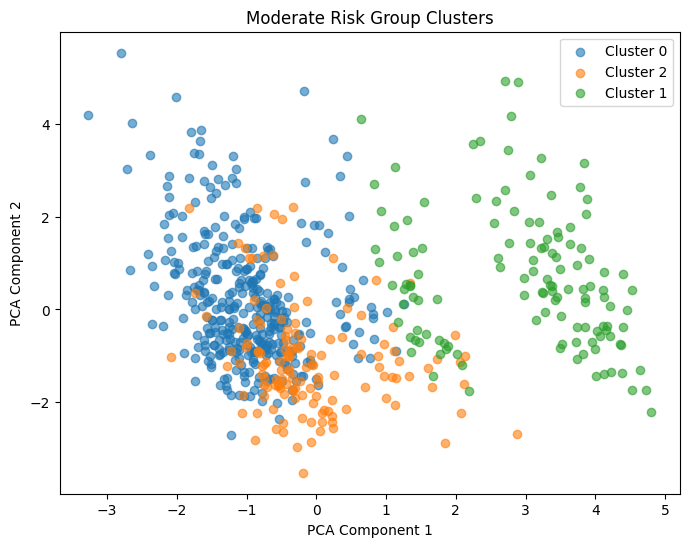

In [324]:
plot_clusters(df_moderate_risk, scaled_moderate, 'Moderate Risk Group Clusters')

In [325]:
print("Numeric feature means per cluster:")
print(df_moderate_risk.groupby('Cluster').mean(numeric_only=True))

Numeric feature means per cluster:
           Tenure        Salary  JobSatisfaction  WorkLifeBalance  \
Cluster                                                             
0        7.722222  69947.222222         3.213889         3.716429   
1        7.703125  63207.031250         3.304688         3.808782   
2        6.611511  60061.151079         3.525180         3.717572   

         PerformanceRating  TrainingHours  OverTime  NumProjects  \
Cluster                                                            
0                 3.584126      24.667763  0.938889     3.854429   
1                 3.598588      70.274335  0.953125     3.802964   
2                 3.600214      27.422625  0.949640     3.799936   

         YearsSincePromotion  EnvironmentSatisfaction  ChurnLikelihoodEncoded  
Cluster                                                                        
0                   1.283333                 3.047274                     1.0  
1                   1.093750          

**Cluster 0** — Higher Salary & More Balanced Workload
Salary: Highest among the three (~69,947).

Job Satisfaction: Slightly lower than Cluster 2, but still decent.

Training Hours: Moderate (~24.7 hours), which might indicate they receive enough skill development without feeling overwhelmed.

NumProjects: Slightly higher (~3.85), suggesting they handle more tasks but not necessarily at the cost of satisfaction.

Possible interpretation: These employees are paid well and have a stable workload, but their job satisfaction isn’t the highest — so salary alone may not prevent churn.

**Cluster 1** — Heavy Training Load
Salary: Mid-range (~63,207).

Training Hours: Extremely high (~70.27 hours) — much higher than the other clusters.

Job Satisfaction: Slightly lower than Cluster 2 despite high training, which may mean the training is either mandatory or stressful.

OverTime: High (95%), which might compound stress.

Possible interpretation: This group may be at risk of burnout due to intense training and overtime, despite their salary being fair.

**Cluster 2** — Shorter Tenure & Higher Job Satisfaction
Tenure: Shortest (~6.6 years).

Job Satisfaction: Highest (~3.53).

Salary: Lowest (~60,061).

YearsSincePromotion: Lowest (~0.83), meaning they may have been promoted recently, boosting morale.

Possible interpretation: This group is newer, recently rewarded (promotion), and still enthusiastic. But low salary could become an issue over time.

*(This cluster is smaller and is located in the middle, overlapping significantly with the blue Cluster 0. It's less distinct than the other two, suggesting that individuals in this group share some characteristics with Cluster 0, but are different enough to be classified separately.)*

In [326]:
categorical_columns = ['Branch', 'MaritalStatus', 'Education', 'Department', 'CommuteDistance']

print("\nMost common category per cluster:")
for col in categorical_columns:
    mode_per_cluster = df_moderate_risk.groupby('Cluster')[col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'None')
    print(f"\n{col}:")
    print(mode_per_cluster)


Most common category per cluster:

Branch:
Cluster
0     Los Angeles
1    Philadelphia
2        Scranton
Name: Branch, dtype: object

MaritalStatus:
Cluster
0    Married
1    Married
2    Married
Name: MaritalStatus, dtype: object

Education:
Cluster
0       Bachelor
1    High School
2       Bachelor
Name: Education, dtype: object

Department:
Cluster
0         Sales
1         Sales
2    Operations
Name: Department, dtype: object

CommuteDistance:
Cluster
0     Short
1     Short
2    Medium
Name: CommuteDistance, dtype: object
